In [1]:
## Uncomment this section to install required packages

#!pip install astroquery
#!pip install Astropy

In [2]:
from astroquery.gaia import Gaia
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from astropy.table import Table, join
import scipy.stats as st
meta_source = Gaia.load_table('gaiadr3.gaia_source')
meta_source
print(meta_source)

Important:  Gaia archive will be intermittently unavailable due to scheduled maintenance on 14-10-2024 from 10:30 to 12:30 (CEST)
TAP Table name: gaiadr3.gaia_source
Description: This table has an entry for every Gaia observed source as published with this data release. It contains the basic source parameters, in their final state as processed by the Gaia Data Processing and Analysis Consortium from the raw data coming from the spacecraft. The table is complemented with others containing information specific to certain kinds of objects (e.g.~Solar--system objects, non--single stars, variables etc.) and value--added processing (e.g.~astrophysical parameters etc.). Further array data types (spectra, epoch measurements) are presented separately via Datalink resources.
Size (bytes): 3646930329600
Num. columns: 152


In [3]:
# This query selects stars from Gaia DR3 that meet the data quality standards for number and consistancy
# of measurements (Babusiaux C, Leeuwen F van, Barstow MA, Jordi C, Vallenari A, et al. 2018. A&A. 616:A10). 

# The color cuts, "bp_rp >l 1.8 AND bp_rp < 5.0 AND g_rp > 0.92 AND g_rp <1.65" limit the selection to M-dwarf stars
# ("A Modern Mean Dwarf Stellar Coor and Effective Temperature Sequence", 
# http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt, # Eric Mamajek, # Version 2022.04.16).

# The final temperature and absolute magnitude cuts, "teff_gspphot < 3900 AND phot_g_mean_mag+5*log10(parallax)-10 > 4"
# remove any M-giant stars.

# Stars are drawn from a strip of sky 20-deg wide centered on 180-deg galactic latitude.

query_M = """
    SELECT TOP 250000
    source_id, phot_g_mean_mag+5*log10(parallax)-10 AS mag_abs, 4.74057*pm*distance_gspphot/1000 AS v_tan,
    ra, dec, l, b, distance_gspphot, parallax,
    phot_g_mean_mag, phot_rp_mean_mag, phot_bp_mean_mag, g_rp, bp_rp, ag_gspphot,
    ebpminrp_gspphot, pm, teff_gspphot, logg_gspphot, mh_gspphot,
    pmdec, pmra
    FROM gaiadr3.gaia_source
    WHERE parallax_over_error > 10
    AND phot_g_mean_flux_over_error>50
    AND phot_rp_mean_flux_over_error>20
    AND phot_bp_mean_flux_over_error>20
    AND phot_bp_rp_excess_factor < 1.3+0.060*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND visibility_periods_used>8
    AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
    AND bp_rp > 1.8 AND bp_rp < 5.0
    AND g_rp > 0.92 AND g_rp <1.65
    AND teff_gspphot < 3900
    AND l>170. AND l<190.
    """

In [4]:
# Run the query. Using the asynchronus query aviods the HTTP timeout 408 error. 

job_M = Gaia.launch_job_async(query_M, output_format = 'votable')
job_M

INFO: Query finished. [astroquery.utils.tap.core]


In [5]:
# Convert results to dataframe and display the results.

results_m = job_M.get_results()
m_dwarf_df = results_m.to_pandas()
N_total = len(m_dwarf_df)
m_dwarf_df

,source_id,mag_abs,v_tan,ra,dec,l,b,distance_gspphot,parallax,phot_g_mean_mag,...,g_rp,bp_rp,ag_gspphot,ebpminrp_gspphot,pm,teff_gspphot,logg_gspphot,mh_gspphot,pmdec,pmra
0,3293764686491591168,9.915977,42.387168,68.646871,10.222125,186.179032,-24.301958,309.097107,2.622567,17.822344,...,1.112200,2.831327,0.8310,0.5162,28.927366,3438.053223,4.5936,-0.6762,-28.799718,-2.714545
1,3293768912739364608,9.972562,63.351640,68.338147,10.134341,186.059727,-24.599019,372.434509,2.421319,18.052301,...,1.119131,2.447287,0.8803,0.5076,35.882061,3636.075928,4.8578,-0.4115,-35.004984,-7.885008
2,3293772490447823232,12.095703,31.409473,68.363118,10.187760,186.028342,-24.547609,111.450996,9.735348,17.153946,...,1.320612,3.283537,0.7373,0.5112,59.449215,3175.282959,4.9768,-0.0440,-56.720740,17.803568
3,3293772589231403392,10.454383,7.266938,68.357965,10.201445,186.012913,-24.543605,185.739395,5.415628,16.786139,...,1.190216,2.706408,0.7314,0.4575,8.253096,3482.824707,4.8564,-0.2279,2.977596,7.697240
4,3293773246362078464,8.498131,13.477387,68.208256,10.199486,185.918718,-24.663517,109.838600,9.005771,13.725527,...,1.005733,2.027662,0.3813,0.2152,25.883329,3877.007812,4.6781,0.0055,-20.249991,-16.120939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,153470765013858176,9.952415,68.416649,72.713389,26.122873,175.352972,-11.568150,23.148701,43.277837,11.771088,...,1.132437,2.428303,0.0000,0.0000,623.454285,3181.490967,4.2123,-0.8807,-244.366061,573.568185
249996,153470799373596032,11.398389,25.330383,72.731389,26.116204,175.368527,-11.559578,125.387703,8.095187,16.857254,...,1.311927,3.106011,0.6468,0.4445,42.614388,3229.045898,4.9243,0.0398,-10.040105,-41.414758
249997,153471825870524032,9.425272,37.607664,72.658669,26.153977,175.296997,-11.587477,296.430786,3.222420,16.884361,...,1.170806,2.626687,1.4256,0.8098,26.762241,3790.293945,4.5849,-0.3568,-26.329345,4.794072
249998,153473067116313472,11.271679,33.416064,72.797677,26.213985,175.327665,-11.452352,148.817505,6.748820,17.125540,...,1.301370,3.198291,0.7382,0.5125,47.366436,3242.179688,4.8959,0.1107,-46.735095,7.707803


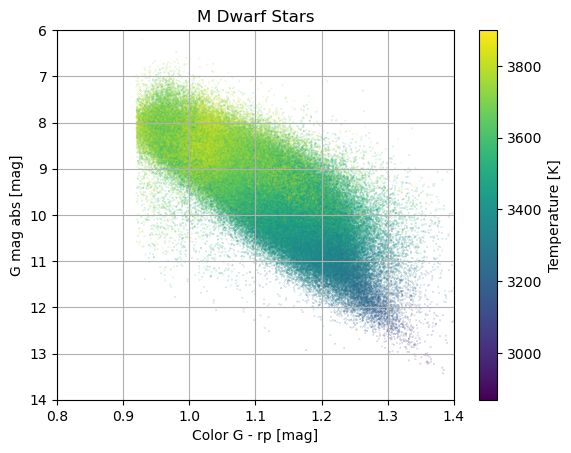

In [6]:
 # Plot and H-R diagram of the M-dwarf stars to verify that the selected stars are on the red dwarf section of the main sequence.

plt.scatter(m_dwarf_df['g_rp'], m_dwarf_df['mag_abs'], s = 0.01, alpha = 1, label = "K-Dwarf", c = m_dwarf_df["teff_gspphot"])
plt.colorbar(label='Temperature [K]')
plt.title('M Dwarf Stars')
plt.xlabel('Color G - rp [mag]')
plt.ylabel('G mag abs [mag]')
plt.xlim(0.8, 1.4)
plt.ylim(14, 6)
plt.grid()
# plt.legend()

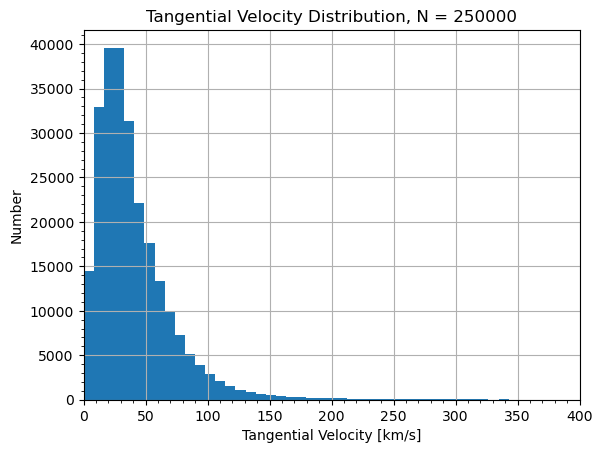

In [7]:
# Tangential velocity histogram

plt.hist(m_dwarf_df['v_tan'], bins=100, density=False)
plt.xlabel('Tangential Velocity [km/s]')
plt.ylabel('Number')
plt.xlim(0,400)
#plt.ylim(0,3000)
plt.title(f'Tangential Velocity Distribution, N = {N_total:.0f}')
plt.grid()
plt.minorticks_on()

# plt.savefig("data/v_tan_hist.png")

In [8]:
# Find low tangental velocity stars. These are potential disk stars.

low_v_tan = m_dwarf_df[m_dwarf_df['v_tan'] < 50]
N_low_v_tan = len(low_v_tan)
low_v_tan

,source_id,mag_abs,v_tan,ra,dec,l,b,distance_gspphot,parallax,phot_g_mean_mag,...,g_rp,bp_rp,ag_gspphot,ebpminrp_gspphot,pm,teff_gspphot,logg_gspphot,mh_gspphot,pmdec,pmra
0,3293764686491591168,9.915977,42.387168,68.646871,10.222125,186.179032,-24.301958,309.097107,2.622567,17.822344,...,1.112200,2.831327,0.8310,0.5162,28.927366,3438.053223,4.5936,-0.6762,-28.799718,-2.714545
2,3293772490447823232,12.095703,31.409473,68.363118,10.187760,186.028342,-24.547609,111.450996,9.735348,17.153946,...,1.320612,3.283537,0.7373,0.5112,59.449215,3175.282959,4.9768,-0.0440,-56.720740,17.803568
3,3293772589231403392,10.454383,7.266938,68.357965,10.201445,186.012913,-24.543605,185.739395,5.415628,16.786139,...,1.190216,2.706408,0.7314,0.4575,8.253096,3482.824707,4.8564,-0.2279,2.977596,7.697240
4,3293773246362078464,8.498131,13.477387,68.208256,10.199486,185.918718,-24.663517,109.838600,9.005771,13.725527,...,1.005733,2.027662,0.3813,0.2152,25.883329,3877.007812,4.6781,0.0055,-20.249991,-16.120939
5,3293773830477619840,8.919980,27.725001,68.272607,10.252524,185.912979,-24.581077,298.140503,3.204433,16.391224,...,1.121164,2.415640,0.9509,0.5481,19.616432,3779.074219,4.5739,-0.2823,-18.873608,-5.347090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249994,155144457933710720,8.513044,42.056752,72.893650,28.684659,173.409915,-9.852461,424.927887,1.805506,17.230049,...,1.017910,2.065786,0.6048,0.3286,20.878050,3722.922363,4.4224,-1.2085,-19.095181,8.441981
249996,153470799373596032,11.398389,25.330383,72.731389,26.116204,175.368527,-11.559578,125.387703,8.095187,16.857254,...,1.311927,3.106011,0.6468,0.4445,42.614388,3229.045898,4.9243,0.0398,-10.040105,-41.414758
249997,153471825870524032,9.425272,37.607664,72.658669,26.153977,175.296997,-11.587477,296.430786,3.222420,16.884361,...,1.170806,2.626687,1.4256,0.8098,26.762241,3790.293945,4.5849,-0.3568,-26.329345,4.794072
249998,153473067116313472,11.271679,33.416064,72.797677,26.213985,175.327665,-11.452352,148.817505,6.748820,17.125540,...,1.301370,3.198291,0.7382,0.5125,47.366436,3242.179688,4.8959,0.1107,-46.735095,7.707803


In [9]:
# Find high tangental velocity stars. These are potential halo stars.

high_v_tan = m_dwarf_df[m_dwarf_df['v_tan'] > 100]
N_high_v_tan = len(high_v_tan)
high_v_tan

,source_id,mag_abs,v_tan,ra,dec,l,b,distance_gspphot,parallax,phot_g_mean_mag,...,g_rp,bp_rp,ag_gspphot,ebpminrp_gspphot,pm,teff_gspphot,logg_gspphot,mh_gspphot,pmdec,pmra
36,3293818223259506304,9.378773,105.648118,68.925245,10.704739,185.929313,-23.796143,1002.636414,1.674983,18.258720,...,1.109787,2.426033,1.0777,0.6121,22.227352,3890.380127,4.3875,-0.0602,-17.161696,14.125558
37,3293819215396280192,9.687300,119.167758,68.886554,10.724183,185.887620,-23.815332,489.101013,1.966006,18.219376,...,1.150410,2.502876,0.8044,0.4843,51.396038,3551.744629,4.5759,-0.6413,-51.375267,1.461097
43,3293825129566916992,8.788501,156.051084,70.267549,9.722150,187.640929,-23.297590,742.120728,1.979273,17.305973,...,1.083450,2.320539,0.8126,0.4680,44.356949,3812.431396,4.3086,-0.1980,-24.527019,36.958955
89,3293864157934057728,8.475696,130.803219,70.844102,10.059554,187.697237,-22.638987,518.208130,1.545867,17.529835,...,1.028452,2.069220,0.6488,0.3516,53.245590,3780.752930,4.4214,-1.2429,-53.245545,0.070365
120,3293880066492881024,9.660731,128.149051,70.493881,10.262599,187.301746,-22.803261,486.032715,2.061280,18.090046,...,1.091900,2.357883,0.6568,0.3796,55.618507,3669.403320,4.7674,-0.3463,-54.566189,-10.767979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249870,150788472039832576,9.448631,272.338130,64.695454,26.612207,170.147684,-16.703448,369.117096,2.406491,17.541710,...,0.995060,2.012743,0.5873,0.3183,155.637314,3835.955078,4.9080,-0.9380,-136.182060,75.348650
249906,150802319014471296,9.724901,224.641377,64.349420,26.427992,170.066815,-17.055319,1057.788452,1.899405,18.331814,...,1.064806,2.259319,0.6801,0.3894,44.798180,3839.989990,4.4771,-0.0101,-44.483203,-5.302976
249910,150803384166342016,8.818093,162.015712,64.464561,26.457781,170.117924,-16.959783,915.043518,1.460385,17.995756,...,1.090057,2.345047,0.6867,0.4034,37.349503,3752.230957,4.3739,-0.1932,-30.167548,22.020542
249922,155116321604997632,-1.088086,117.141733,72.115478,28.317316,173.266699,-10.615838,5275.339844,0.355604,11.157083,...,1.243511,2.949752,1.3996,0.8236,4.684148,3750.056396,0.7970,0.6220,-3.946402,2.523323


In [10]:
# Save the files high and low tangential velocity files as csv.

high_v_tan.to_csv('dataset/high_v_tan.csv')
low_v_tan.to_csv('dataset/low_v_tan.csv')

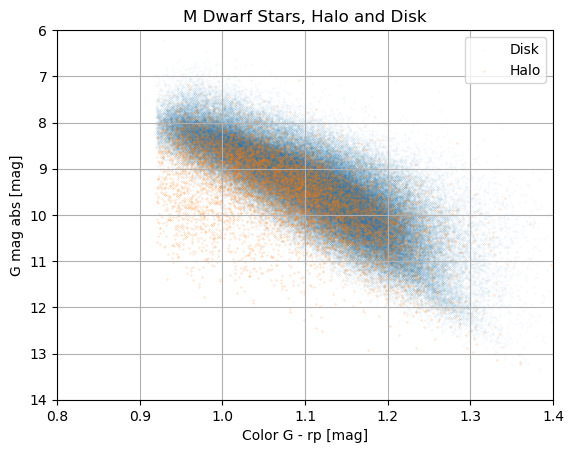

In [11]:
# Plot an HR diagram of the two groups.

plt.scatter(low_v_tan['g_rp'], low_v_tan['mag_abs'], s = 0.01, alpha = 0.25, label = "Disk")
plt.scatter(high_v_tan['g_rp'], high_v_tan['mag_abs'], s = 0.05, alpha = 0.5, label = "Halo")
# plt.colorbar(label='Metallicity [dex]')
plt.title('M Dwarf Stars, Halo and Disk')
plt.xlabel('Color G - rp [mag]')
plt.ylabel('G mag abs [mag]')
plt.xlim(0.8, 1.4)
plt.ylim(14, 6)
plt.grid()
plt.legend()

#plt.savefig("data/hr_diagram.png")

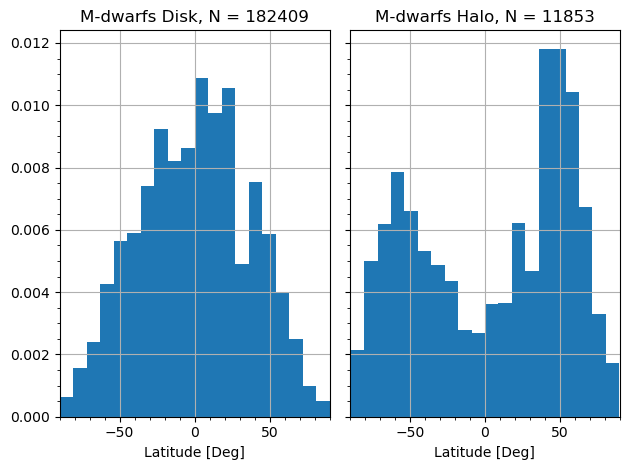

In [13]:
# Compare galactic latitude of halo and disk stars

bins = 20
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
N2=42
axs[0].hist(low_v_tan['b'], bins=bins, density=True)
axs[0].set_xlabel('Latitude [Deg]')
axs[0].set_xlim(-90,90)
#axs[0].set_ylim(0,1.2)
axs[0].set_title(f'M-dwarfs Disk, N = {N_low_v_tan:.0f}')
axs[0].grid()
axs[0].minorticks_on()

axs[1].hist(high_v_tan['b'], bins=bins, density=True)
axs[1].set_xlabel('Latitude [Deg]')
axs[1].set_xlim(-90,90)
#axs[1].set_ylim(0,1.2)
axs[1].set_title(f'M-dwarfs Halo, N = {N_high_v_tan:.0f}')
axs[1].grid()
axs[1].minorticks_on()

plt.savefig("dataset/v_tan_hist.png")

In [14]:
# Trim data files to save space. Remove photometry data and keep position data.

high_v_tan_position = high_v_tan.drop(['ra', 'dec', 'distance_gspphot', 'parallax',
    'phot_g_mean_mag', 'phot_rp_mean_mag', 'phot_bp_mean_mag', 'bp_rp', 'ag_gspphot',
    'ebpminrp_gspphot', 'pm', 'teff_gspphot', 'logg_gspphot', 'mh_gspphot',
    'pmdec', 'pmra'], axis=1)
low_v_tan_position = low_v_tan.drop(['ra', 'dec', 'distance_gspphot', 'parallax',
    'phot_g_mean_mag', 'phot_rp_mean_mag', 'phot_bp_mean_mag', 'bp_rp', 'ag_gspphot',
    'ebpminrp_gspphot', 'pm', 'teff_gspphot', 'logg_gspphot', 'mh_gspphot',
    'pmdec', 'pmra'], axis=1)

# Save the files.
high_v_tan_position.to_csv('dataset/high_v_tan_position.csv')
low_v_tan_position.to_csv('dataset/low_v_tan_position.csv')